# <u>**Lesson 1**</u>
Adding convolution network

Updating the helper function


In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 69ms/step - loss: 73.2144 - mae: 73.7136
Epoch 2/100
8/8 [==============================] - 1s 71ms/step - loss: 71.8829 - mae: 72.3820
Epoch 3/100
8/8 [==============================] - 1s 70ms/step - loss: 71.1747 - mae: 71.6739
Epoch 4/100
8/8 [==============================] - 1s 74ms/step - loss: 69.8038 - mae: 70.3031
Epoch 5/100
8/8 [==============================] - 1s 76ms/step - loss: 69.3436 - mae: 69.8427
Epoch 6/100
8/8 [==============================] - 1s 75ms/step - loss: 66.7656 - mae: 67.2644
Epoch 7/100
8/8 [==============================] - 1s 67ms/step - loss: 64.1345 - mae: 64.6338
Epoch 8/100
8/8 [==============================] - 1s 68ms/step - loss: 62.0534 - mae: 62.5524
Epoch 9/100
8/8 [==============================] - 1s 69ms/step - loss: 59.5496 - mae: 60.0484
Epoch 10/100
8/8 [==============================] - 1s 69ms/step - loss: 56.8676 - mae: 57.3663
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

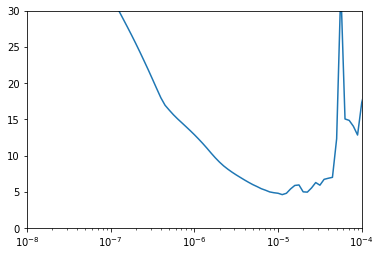

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 22ms/step - loss: 33.5999 - mae: 34.0956
Epoch 2/500
31/31 [==============================] - 1s 23ms/step - loss: 8.4929 - mae: 8.9781
Epoch 3/500
31/31 [==============================] - 1s 23ms/step - loss: 6.9030 - mae: 7.3851
Epoch 4/500
31/31 [==============================] - 1s 23ms/step - loss: 6.3056 - mae: 6.7856
Epoch 5/500
31/31 [==============================] - 1s 25ms/step - loss: 5.7221 - mae: 6.2019
Epoch 6/500
31/31 [==============================] - 1s 23ms/step - loss: 5.7311 - mae: 6.2118
Epoch 7/500
31/31 [==============================] - 1s 24ms/step - loss: 5.6260 - mae: 6.1051
Epoch 8/500
31/31 [==============================] - 1s 23ms/step - loss: 5.3659 - mae: 5.8451
Epoch 9/500
31/31 [==============================] - 1s 24ms/step - loss: 5.3749 - mae: 5.8540
Epoch 10/500
31/31 [==============================] - 1s 24ms/step - loss: 5.1568 - mae: 5.6356
Epoch 11/500
31/31 [===========================

In [22]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

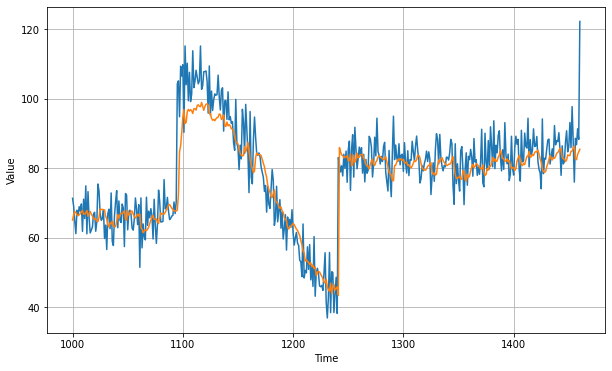

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1123223

<Figure size 432x288 with 0 Axes>

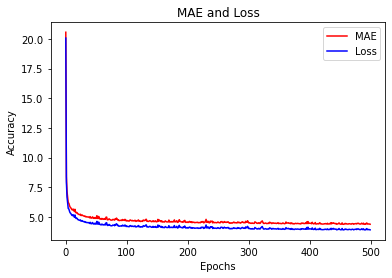

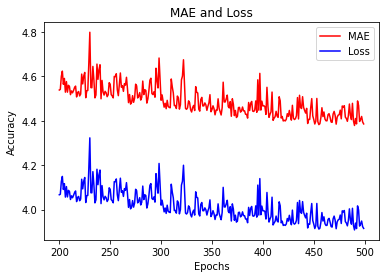

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# <u>**Lesson 2: Sunspot Data**</u>
Over the last few weeks, you looked at time-series data and examined a few techniques for forecasting that data including statistical analysis, linear regression, and machine-learning with both deep learning networks and recurrent neural networks. 


In [26]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [27]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [29]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-05-09 11:03:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-05-09 11:03:19 (118 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



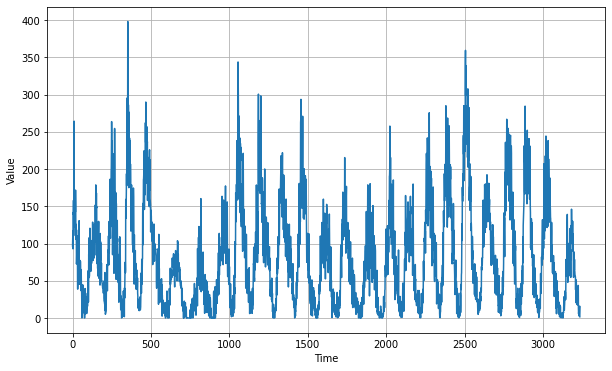

In [30]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Our clue to the problem could be our window size. Remember earlier we said it's a 20 so our training window sizes are 20 time slices worth of data. And given that each time slice is a month in real time our window is a little under two years. 

But if you remember this chart, we can see that the seasonality of sunspots is far greater than two years. It's closer to 11 years and actually some science tells us that it might even be 22 years with different cycles interleaguing with each other. So what would happen if we retrain with a window size of 132, which is 11 years worth of data as our window size. Now while this chart looks similar, we can see from the MAE that it actually got worse so increasing the window size didn't work. Why do you think that would be?

Well, by looking back to the data, we can realize that it is seasonal to about 11 years, but we don't need a full season in our window. Zooming in on the data again, we'll see something like this where it's just the typical time series. Values later on are somewhat related to earlier ones, but that's a lot of noise. So maybe we don't need a huge window of time in order to train. Maybe we should go with something a little bit more like our initial 20, let's try 30.

So if we look back at this code, we can change our window size to 30. But then look at the split time, the data set has around 3,500 items of data, but we're splitting it into training and validation. Now 1,000, which means only 1,000 for training and 2,500 for validation. That's a really bad split. There's not enough training data. So let's make it 3,500 instead. And then when we retrain, we'll get this. Our MAE has improved to 15 but can we make it even better?

In [31]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Well, one thing we can try is to edit the neural network design and height of parameters. If you remember, we had three layers of 10, 10, and 1 neurons. Our input shape is now larger at 30. So maybe try different values here, like 30, 15, and 1, and retrain.

Surprisingly, this was a small step backwards, with our MAE increasing.

It also wasn't worth the extra compute time for the extra neuron layers. So let's switch back to 10, 10, 1 and instead look at the learning rate.

In [33]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

The window size I'm using is 30 steps, and the dataset is 3,235 steps long. So if I want to predict the next value after the end of my dataset, I would use this code. And I would get the result 7.0773993.

The dataset goes up to July 2018, so I'm actually predicting 7.077 sunspots for August 2018. And if I look at this chart of observations, which does have some slightly different data from my dataset, I can see that the actual recorded number of sunspots in August 2018 was 8.7.

With these settings, I got the MAE down to 13.75, and the prediction was 8.13, which is much closer to the actual real reading of 8.7. There is a random elements in creating models, however, so your results may vary. Doing accuracy based on a single prediction like this is also a recipe for disappointment, and you're much better off evaluating mean accuracy over a number of readings.

So here, we looked at using a DNN to predict sunspot values. With a little bit of tuning, we reduced our MAE a bit. And when we tried to predict the next month's value using this model, we got quite close to the actual value.

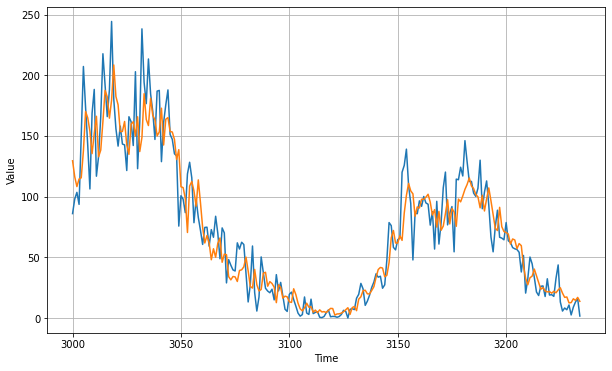

In [34]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [35]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.110336

You should get slightly different values due to the randomness of the model initialization and stochastic gradient descent. 

# <u>**Lesson 3: Combining All And Tunning Hyper-parameter**</u>


In [52]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [53]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [54]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-05-09 11:18:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-05-09 11:18:15 (112 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



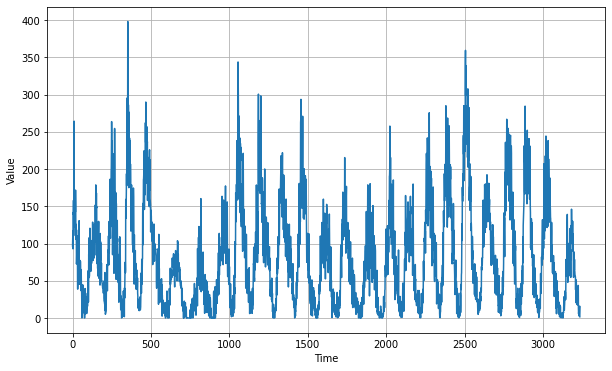

In [55]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

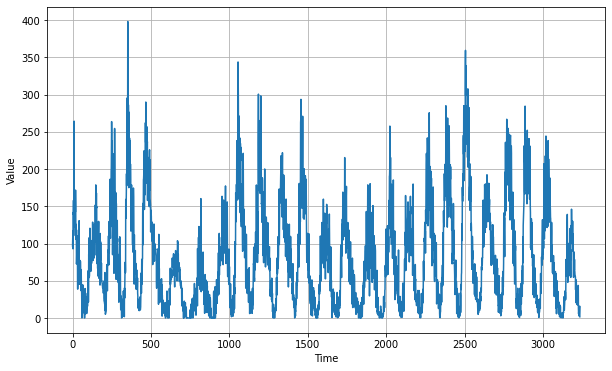

In [56]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [57]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [62]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [63]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [64]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 8s 297ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 4s 296ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 4s 299ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 4s 296ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 4s 298ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 4s 300ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 4s 295ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 4s 295ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 4s 298ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/

(1e-08, 0.0001, 0.0, 60.0)

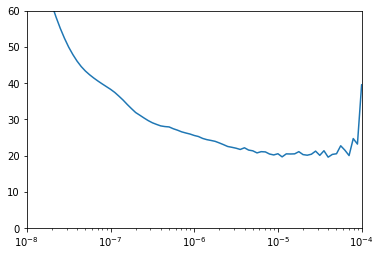

In [65]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [66]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 113ms/step - loss: 47.7137 - mae: 48.2109
Epoch 2/500
30/30 [==============================] - 4s 115ms/step - loss: 26.8720 - mae: 27.3669
Epoch 3/500
30/30 [==============================] - 4s 114ms/step - loss: 22.9778 - mae: 23.4724
Epoch 4/500
30/30 [==============================] - 4s 115ms/step - loss: 20.2820 - mae: 20.7753
Epoch 5/500
30/30 [==============================] - 4s 113ms/step - loss: 19.0068 - mae: 19.4986
Epoch 6/500
30/30 [==============================] - 4s 114ms/step - loss: 19.1465 - mae: 19.6385
Epoch 7/500
30/30 [==============================] - 4s 114ms/step - loss: 18.4978 - mae: 18.9894
Epoch 8/500
30/30 [==============================] - 4s 114ms/step - loss: 18.0319 - mae: 18.5232
Epoch 9/500
30/30 [==============================] - 4s 114ms/step - loss: 18.1642 - mae: 18.6554
Epoch 10/500
30/30 [==============================] - 4s 113ms/step - loss: 19.7740 - mae: 20.2661
Epoch 11/500
30/30 

In [67]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

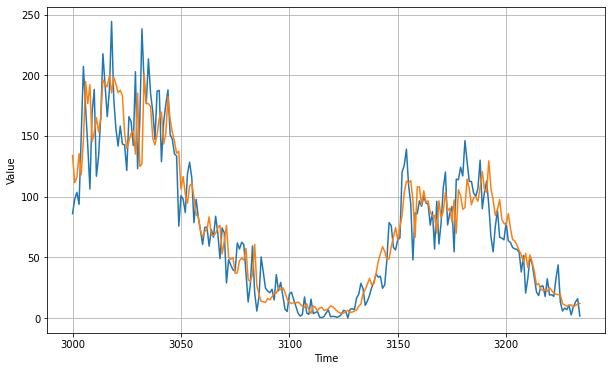

In [68]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [69]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.563733

<Figure size 432x288 with 0 Axes>

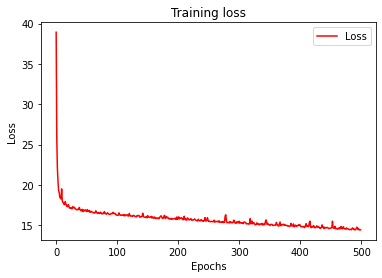

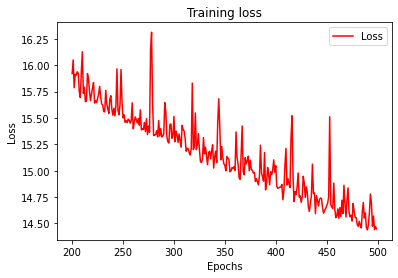

<Figure size 432x288 with 0 Axes>

In [70]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [71]:
print(rnn_forecast)

[133.86688   111.423805  115.95533   135.33765   117.97729   146.20572
 194.91243   176.58174   192.16011   145.05191   153.02274   164.96251
 153.32277   164.63734   196.19318   192.64333   190.55417   199.91469
 185.38148   198.20222   192.71736   185.60817   187.6921    183.2837
 152.36525   139.6168    145.59373   152.15611   154.51826   135.01263
 185.15196   124.83418   127.0245    201.48062   176.70314   176.69986
 174.21355   147.92514   142.54039   151.19281   164.48863   169.62912
 143.34987   151.93816   182.32211   164.04097   153.14157   145.50035
 135.74567   137.32808   106.24745   116.539894  102.26559    94.592606
 108.81598   110.74693    99.526436   85.29563    83.44363    71.62722
  66.86533    71.2244     73.087296   83.279785   68.44928    68.01071
  69.66847    74.41801    76.364395   52.788662   63.327374   76.29181
  49.932068   48.331852   49.81824    36.724575   37.29638    47.113686
  49.255337   47.69706    57.3641     31.602547   30.19172    35.825516
  60

# <u>**Exercise 4 - Sunspots**</u>
This week you moved away from synthetic data to do a real-world prediction -- sunspots. You loaded data from CSV and built models to use it. For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)

#What next?

Ready to deploy your models to the world? Learn how to go live with your models with the [TensorFlow: Data and Deployment Specialization](https://bit.ly/3ojuT1o).

Looking to customize and build powerful real-world models for complex scenarios? Check out the [TensorFlow: Advanced Techniques Specialization](https://bit.ly/39iAsZQ). 

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-05-09 14:13:31--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2021-05-09 14:13:32 (9.65 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



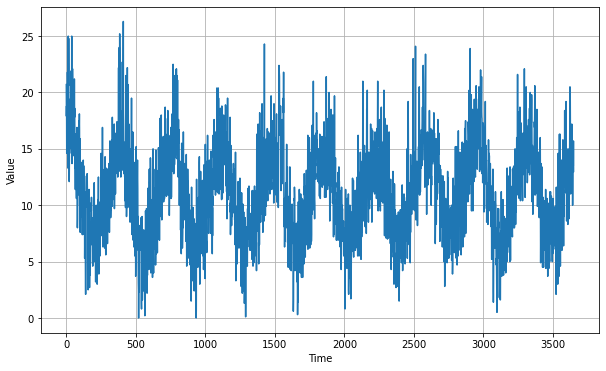

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile,delimiter=',')
  next(reader)
  i = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(i)
    i+=1
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time_step[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time_step[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [89]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 296ms/step - loss: 36.9010 - mae: 37.4004
Epoch 2/100
10/10 [==============================] - 3s 288ms/step - loss: 36.2211 - mae: 36.7204
Epoch 3/100
10/10 [==============================] - 3s 288ms/step - loss: 34.9594 - mae: 35.4587
Epoch 4/100
10/10 [==============================] - 3s 290ms/step - loss: 33.3239 - mae: 33.8230
Epoch 5/100
10/10 [==============================] - 3s 293ms/step - loss: 31.4519 - mae: 31.9507
Epoch 6/100
10/10 [==============================] - 3s 288ms/step - loss: 29.3842 - mae: 29.8827
Epoch 7/100
10/10 [==============================] - 3s 289ms/step - loss: 27.0776 - mae: 27.5756
Epoch 8/100
10/10 [==============================] - 3s 290ms/step - loss: 24.3575 - mae: 24.8549
Epoch 9/100
10/10 [==============================] - 3s 294ms/step - loss: 21.3468 - mae: 21.8435
Epoch 10/100
10/

(1e-08, 0.0001, 0.0, 60.0)

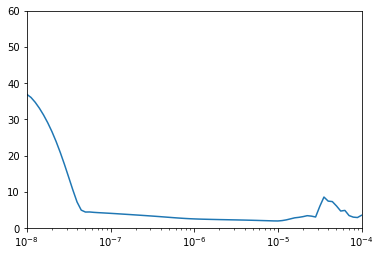

In [90]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150,verbose =1)# YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 5s 88ms/step - loss: 15.8472 - mae: 16.3396
Epoch 2/150
25/25 [==============================] - 2s 89ms/step - loss: 2.9314 - mae: 3.3996
Epoch 3/150
25/25 [==============================] - 2s 88ms/step - loss: 2.0152 - mae: 2.4714
Epoch 4/150
25/25 [==============================] - 2s 86ms/step - loss: 1.9115 - mae: 2.3666
Epoch 5/150
25/25 [==============================] - 2s 90ms/step - loss: 1.8753 - mae: 2.3297
Epoch 6/150
25/25 [==============================] - 2s 94ms/step - loss: 1.8384 - mae: 2.2916
Epoch 7/150
25/25 [==============================] - 2s 91ms/step - loss: 1.8145 - mae: 2.2667
Epoch 8/150
25/25 [==============================] - 2s 92ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 2s 93ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 2s 87ms/step - loss: 1.7410 - mae: 2.1911
Epoch 11/150
25/25 [===========================

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

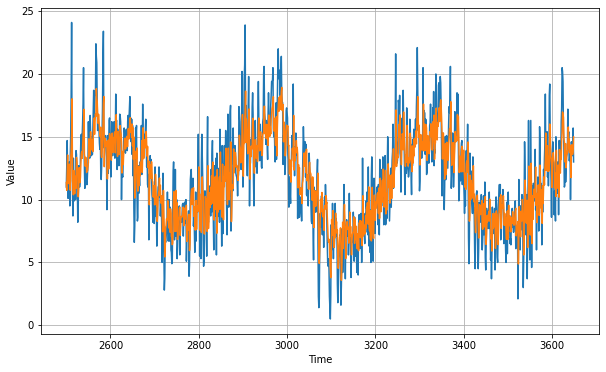

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7836281

In [13]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.35325  10.742305 12.154226 ... 13.590619 13.768208 14.992867]
